In [1]:
import sys
sys.path.append("/global/home/users/avirukt/name/")
from power_spectrum import *

In [2]:
tf.enable_eager_execution()

In [5]:
warnings.filterwarnings('ignore')

In [147]:
feature_description = {
    'field': tf.FixedLenFeature([2**16], tf.float32),
    "params": tf.FixedLenFeature([3], tf.float32)
}

feature_description_with_mask = {
    'field': tf.FixedLenFeature([2**16], tf.float32),
    "params": tf.FixedLenFeature([3], tf.float32),
    "mask": tf.FixedLenFeature([2**16], tf.float32)
}

data_path = lambda x: ["/global/scratch/avirukt/jia_sims/%s/%04d.tfrecord"%(x,i) for i in range(10000)]

def parse(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    d = tf.parse_single_example(example_proto, feature_description)
    return (tf.reshape(d["field"],(256,256)),d["params"])

def parse_with_mask(example_proto):
    d = tf.parse_single_example(example_proto, feature_description_with_mask)
    return (tf.reshape(d["field"],(256,256)),d["params"],tf.reshape(d["mask"],(256,256)))

def dataset(version):
    d = tf.data.TFRecordDataset(data_path(version), buffer_size=int(1.2*256**2*4))
    if "random_mask" in version:
        d = d.map(parse_with_mask)
    else:
        d = d.map(parse)
    return d.make_one_shot_iterator()

def plot_images(versions,figsize=10):
    n = len(versions)
    datasets = [dataset(v) for v in versions]
    while True:
        data = [next(d) for d in datasets]
        params = data[0][1].numpy()
        print(params)
        for i in range(1,n):
            if any(data[i][1].numpy() != params):
                print("whoopsie %d"%i)
        f,ax = subplots(1, n, sharex=True, sharey=True, figsize=(n*figsize,figsize+1))
        for i in range(n):
            ax[i].set_title(versions[i])
            ax[i].imshow(data[i][0].numpy(), cmap=cm.viridis)
        yield

In [148]:
versions = ["noiseless","noiseless_whitened","noiseless_gaussian"]
images = plot_images(versions)

[0.     0.3    0.8523]


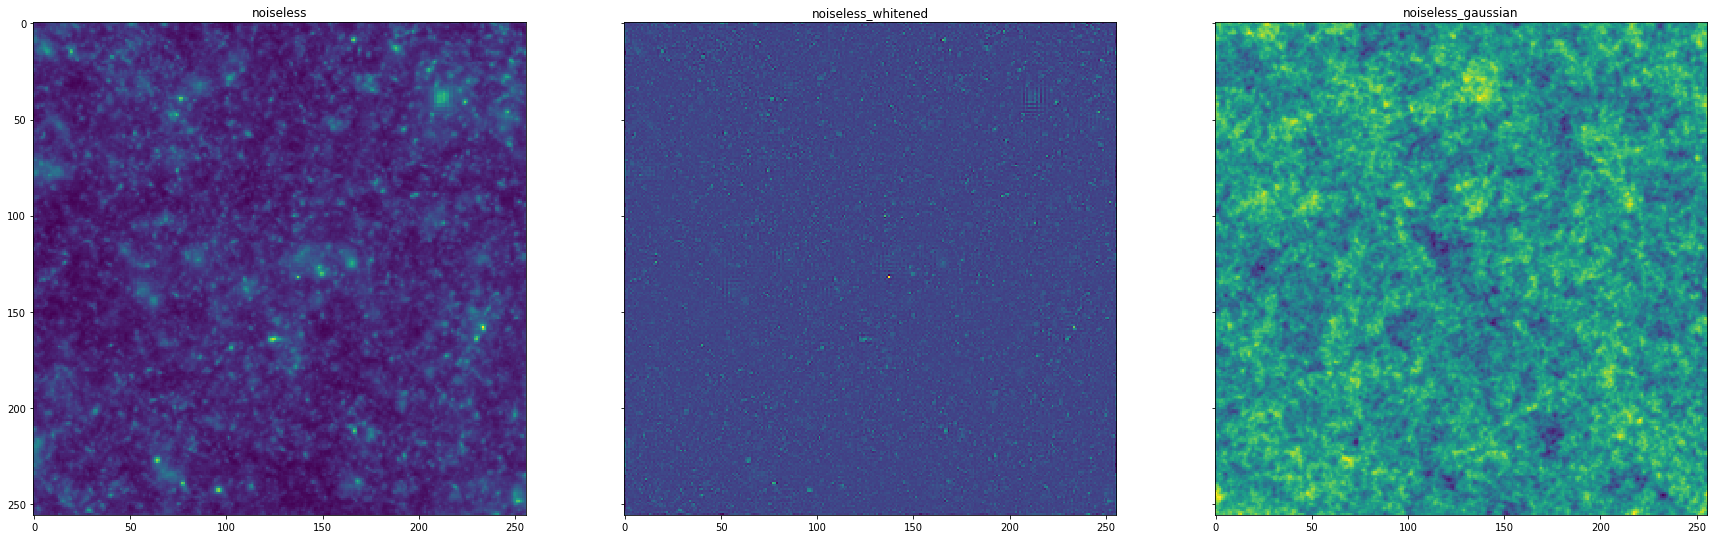

In [149]:
next(images)

In [150]:
def compare_ps(versions):
    n = len(versions)
    datasets = [dataset(v) for v in versions]
    while True:
        for i in range(n):
            loglog(*dynamic_ps(next(datasets[i])[0].numpy())[:2], label=versions[i])
        legend(frameon=False)
        yield

spectra = compare_ps(versions)

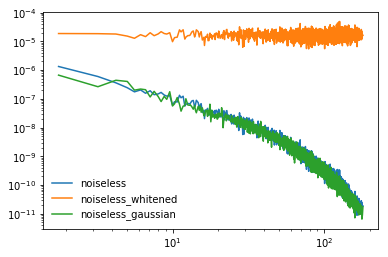

In [151]:
next(spectra)

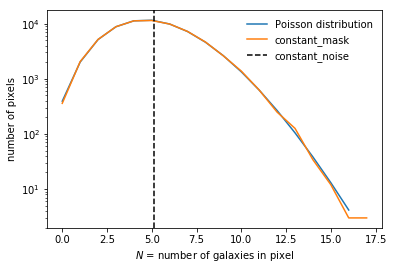

In [170]:
from scipy.stats import poisson

mask = load("/global/scratch/avirukt/jia_sims/constant_mask/mask.npy")
plot(2**16*poisson.pmf(arange(amax(mask)),5.12),label="Poisson distribution")
plot(bincount(mask.flatten()),label="constant_mask")
axvline(mean(mask),c="k",ls="--",label="constant_noise")
xlabel("$N$ = number of galaxies in pixel")
ylabel("number of pixels")
legend(frameon=False)
yscale("log")

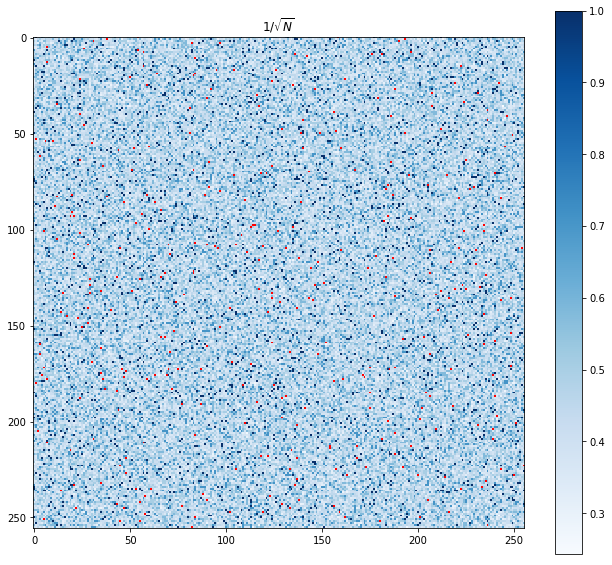

In [155]:
figure(figsize=(11,10))
title(r"$1/\sqrt{N}$")
cmap = cm.Blues
cmap.set_bad('red',1.)
imshow(1/sqrt(mask), cmap=cmap)
colorbar()

In [153]:
versions = ["noiseless","constant_noise","constant_mask","random_mask"]
plots = plot_data(versions)

[0.     0.3    0.8523]


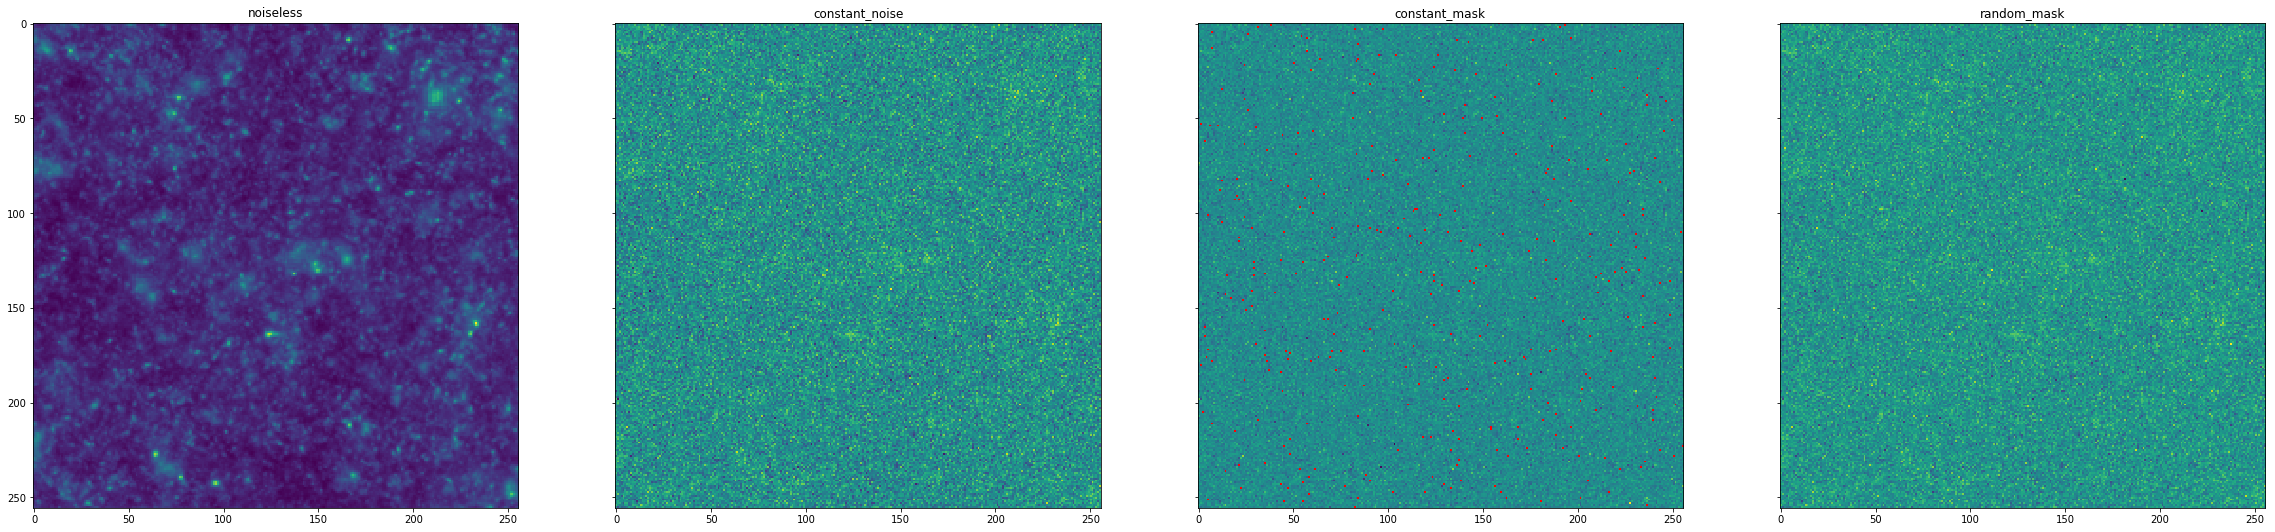

In [154]:
next(plots)

In [30]:
next(datasets[1])[1].numpy()

array([0.    , 0.3   , 0.8523], dtype=float32)

In [156]:
d = dataset("random_mask")

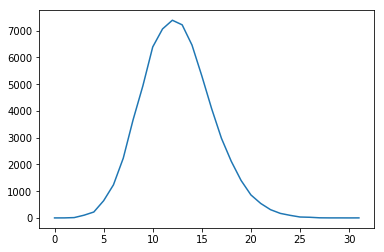

In [175]:
plot(bincount(next(d)[2].numpy().astype(int).flatten()))